# Custom CNN architecture

In [1]:
# Run the previous notebook to load all its classes and functions
%run busi_augmentation_2.ipynb

Found 210 images and 211 masks in malignant folder


Processing malignant masks: 100%|███████████████████████████████████████████████████| 211/211 [00:00<00:00, 653.24it/s]


Found 133 images and 133 masks in normal folder


Processing normal masks: 100%|██████████████████████████████████████████████████████| 133/133 [00:00<00:00, 285.40it/s]


Found 437 images and 454 masks in benign folder


Processing benign masks: 100%|██████████████████████████████████████████████████████| 454/454 [00:00<00:00, 604.77it/s]


Combined 2 masks for malignant (53).png
Combined 2 masks for benign (100).png
Combined 2 masks for benign (163).png
Combined 2 masks for benign (173).png
Combined 2 masks for benign (181).png
Combined 3 masks for benign (195).png
Combined 2 masks for benign (25).png
Combined 2 masks for benign (315).png
Combined 2 masks for benign (346).png
Combined 2 masks for benign (4).png
Combined 2 masks for benign (424).png
Combined 2 masks for benign (54).png
Combined 2 masks for benign (58).png
Combined 2 masks for benign (83).png
Combined 2 masks for benign (92).png
Combined 2 masks for benign (93).png
Combined 2 masks for benign (98).png
Dataset shape: (780, 224, 224, 1)
Masks shape: (780, 224, 224, 1)
Labels shape: (780,)
Class distribution: Normal: 133, Benign: 437, Malignant: 210
Original training set: (624, 224, 224, 1), (624,), masks: (780, 224, 224, 1)
Augmented training set: (2008, 224, 224, 1), (2008,), masks: (2008, 224, 224, 1)
Augmented Normal: 636 samples
Augmented Benign: 700 sam

In [2]:


import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score, precision_score, recall_score, f1_score

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Input, LeakyReLU
from tensorflow.keras.utils import plot_model
from tensorflow.keras.optimizers import Adam
import tensorflow as tf
from tensorflow.keras.datasets import mnist, cifar10
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dropout

import seaborn as sns
import time





In [3]:
print(X_aug.shape)
print(y_aug.shape)
print(masks_aug.shape)

(2008, 224, 224, 1)
(2008,)
(2008, 224, 224, 1)


In [4]:
print(y_aug[2000])

1


# Apply MINMAX normalization

In [5]:
X = X_aug.astype("float32") / 255.0
masks = masks_aug.astype("float32") / 255.0
y = y_aug
print(X[0][55])
print(y[0])
print(masks[0][55])



[[0.7019608 ]
 [0.54509807]
 [0.43137255]
 [0.38431373]
 [0.3647059 ]
 [0.40392157]
 [0.47058824]
 [0.50980395]
 [0.5803922 ]
 [0.6117647 ]
 [0.6       ]
 [0.6039216 ]
 [0.68235296]
 [0.74509805]
 [0.68235296]
 [0.6509804 ]
 [0.62352943]
 [0.6784314 ]
 [0.6666667 ]
 [0.49019608]
 [0.43529412]
 [0.3529412 ]
 [0.2509804 ]
 [0.17254902]
 [0.19215687]
 [0.24313726]
 [0.5176471 ]
 [0.8117647 ]
 [0.77254903]
 [0.7372549 ]
 [0.70980394]
 [0.7254902 ]
 [0.69803923]
 [0.7019608 ]
 [0.7137255 ]
 [0.69803923]
 [0.64705884]
 [0.5686275 ]
 [0.6117647 ]
 [0.6       ]
 [0.5294118 ]
 [0.56078434]
 [0.59607846]
 [0.6039216 ]
 [0.6156863 ]
 [0.6509804 ]
 [0.6666667 ]
 [0.6901961 ]
 [0.73333335]
 [0.73333335]
 [0.68235296]
 [0.6509804 ]
 [0.6862745 ]
 [0.7411765 ]
 [0.78039217]
 [0.8039216 ]
 [0.77254903]
 [0.7490196 ]
 [0.78039217]
 [0.84705883]
 [0.84705883]
 [0.827451  ]
 [0.83137256]
 [0.7882353 ]
 [0.7411765 ]
 [0.75686276]
 [0.70980394]
 [0.60784316]
 [0.54901963]
 [0.5803922 ]
 [0.6431373 ]
 [0.68

In [7]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Input, Conv2D, MaxPooling2D, Flatten, Dense, Dropout, LeakyReLU
from tensorflow.keras.callbacks import EarlyStopping
from sklearn.model_selection import train_test_split

# Early stopping
#early_stop = EarlyStopping(patience=5, restore_best_weights=True, verbose=1)

#Hyperparameter options
# nr_filters_layer_1 = [64, 128]
# kernel_sizes = [(2, 2), (3, 3)]
# activations = [
#     ("relu", "relu"),
#     ("leakyrelu", LeakyReLU(negative_slope=0.01))
# ]
# dropout_sizes = [0.4, 0.5]

nr_filters_layer_1 = [64]
kernel_sizes = [(3, 3)]
activations = [
    ("relu", "relu")
]
dropout_sizes = [0.5]

histories = []

# Train/test split
# X_train, X_test, y_train, y_test = train_test_split(
#     X, y, test_size=0.2, random_state=13, stratify=y
# )

for nr_filters_layer_1_option in nr_filters_layer_1:
    for kernel_size_option in kernel_sizes:
        for activation_name, activation_fn in activations:
            for dropout_size in dropout_sizes:
                print(
                    f"Training model with: "
                    f"nr_filters={nr_filters_layer_1_option}, "
                    f"kernel_size={kernel_size_option}, "
                    f"activation={activation_name}, "
                    f"dropout={dropout_size}"
                )

                # Model definition
                model = Sequential([
                    Input(shape=(224, 224, 1)),
                    Conv2D(nr_filters_layer_1_option, kernel_size=kernel_size_option, activation=activation_fn),
                    MaxPooling2D(pool_size=(2, 2)),

                    Conv2D(nr_filters_layer_1_option, kernel_size=kernel_size_option, activation=activation_fn),
                    MaxPooling2D(pool_size=(2, 2)),

                    Conv2D(nr_filters_layer_1_option * 2, kernel_size=kernel_size_option, activation=activation_fn),
                    MaxPooling2D(pool_size=(2, 2)),

                    Flatten(),
                    Dense(128, activation=activation_fn),
                    Dropout(dropout_size),
                    Dense(3, activation='softmax')
                ])

                # Compile
                model.compile(
                    optimizer='adam',
                    loss='sparse_categorical_crossentropy',
                    metrics=['accuracy']
                )

                # Train
                history = model.fit(
                    X, y,
                    validation_split=0.2,
                    epochs=15,
                    batch_size=32
                )

                # Save
                label = (
                    f"nr_filters={nr_filters_layer_1_option}, "
                    f"kernel_size={kernel_size_option}, "
                    f"activation={activation_name}, "
                    f"dropout={dropout_size}"
                )
                histories.append((label, history))


Training model with: nr_filters=64, kernel_size=(3, 3), activation=relu, dropout=0.5
Epoch 1/15
51/51 ━━━━━━━━━━━━━━━━━━━━ 49s 920ms/step - accuracy: 0.3508 - loss: 1.1782 - val_accuracy: 0.5398 - val_loss: 1.0350
Epoch 2/15
51/51 ━━━━━━━━━━━━━━━━━━━━ 45s 891ms/step - accuracy: 0.5640 - loss: 0.9480 - val_accuracy: 0.6045 - val_loss: 0.9165
Epoch 3/15
51/51 ━━━━━━━━━━━━━━━━━━━━ 45s 877ms/step - accuracy: 0.7415 - loss: 0.6123 - val_accuracy: 0.6542 - val_loss: 0.9515
Epoch 4/15
51/51 ━━━━━━━━━━━━━━━━━━━━ 45s 887ms/step - accuracy: 0.8680 - loss: 0.3396 - val_accuracy: 0.6716 - val_loss: 1.1264
Epoch 5/15
51/51 ━━━━━━━━━━━━━━━━━━━━ 45s 883ms/step - accuracy: 0.9417 - loss: 0.1801 - val_accuracy: 0.6891 - val_loss: 1.3727
Epoch 6/15
51/51 ━━━━━━━━━━━━━━━━━━━━ 46s 898ms/step - accuracy: 0.9620 - loss: 0.1135 - val_accuracy: 0.6940 - val_loss: 1.5476
Epoch 7/15
51/51 ━━━━━━━━━━━━━━━━━━━━ 46s 893ms/step - accuracy: 0.9742 - loss: 0.0652 - val_accuracy: 0.6766 - val_loss: 1.5778
Epoch 8/15
5

In [7]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Input, Conv2D, BatchNormalization, Activation, MaxPooling2D
from tensorflow.keras.layers import Flatten, Dense, Dropout

In [8]:
model = Sequential([
    # Input layer (grayscale images 224x224x1)
    Input(shape=(224, 224, 1)),

    # Convolutional layer: 20 filters, kernel size 5x5
    Conv2D(20, (5, 5), padding="same"),
    
    # Batch Normalization (20 channels)
    BatchNormalization(),
    
    # ReLU activation
    Activation("relu"),
    
    # MaxPooling
    MaxPooling2D(pool_size=(2, 2)),
    
    # Flatten before fully connected
    Flatten(),
    
    # Fully connected layer (let’s use 128 units)
    Dense(128, activation="relu"),
    
    # Dropout 50%
    Dropout(0.5),
    
    # Output layer with 3 classes
    Dense(3, activation="softmax")
])

In [9]:
# Compile
model.compile(
    optimizer='adam',
    loss='sparse_categorical_crossentropy',
    metrics=['accuracy']
)

# Train
history = model.fit(
    X, y,
    validation_split=0.2,
    epochs=40,
    batch_size=32
)

a= 69
# Save
label = (
    f"nr_filters={a}, "
    f"kernel_size={a}, "
    f"activation={a}, "
    f"dropout={a}"
)
histories.append((label, history))

Epoch 1/40
51/51 ━━━━━━━━━━━━━━━━━━━━ 37s 711ms/step - accuracy: 0.3473 - loss: 52.1395 - val_accuracy: 0.3955 - val_loss: 1.0820
Epoch 2/40
51/51 ━━━━━━━━━━━━━━━━━━━━ 36s 714ms/step - accuracy: 0.3415 - loss: 1.1813 - val_accuracy: 0.4204 - val_loss: 1.0980
Epoch 3/40
51/51 ━━━━━━━━━━━━━━━━━━━━ 36s 712ms/step - accuracy: 0.3106 - loss: 1.0966 - val_accuracy: 0.4055 - val_loss: 1.0991
Epoch 4/40
51/51 ━━━━━━━━━━━━━━━━━━━━ 37s 722ms/step - accuracy: 0.3253 - loss: 1.0957 - val_accuracy: 0.3085 - val_loss: 1.0990
Epoch 5/40
51/51 ━━━━━━━━━━━━━━━━━━━━ 37s 729ms/step - accuracy: 0.3413 - loss: 1.1064 - val_accuracy: 0.3085 - val_loss: 1.0984
Epoch 6/40
51/51 ━━━━━━━━━━━━━━━━━━━━ 37s 718ms/step - accuracy: 0.3486 - loss: 1.0951 - val_accuracy: 0.3085 - val_loss: 1.0984
Epoch 7/40
51/51 ━━━━━━━━━━━━━━━━━━━━ 37s 721ms/step - accuracy: 0.3235 - loss: 1.0985 - val_accuracy: 0.3134 - val_loss: 1.0967
Epoch 8/40
51/51 ━━━━━━━━━━━━━━━━━━━━ 37s 716ms/step - accuracy: 0.3525 - loss: 1.0938 - val_acc

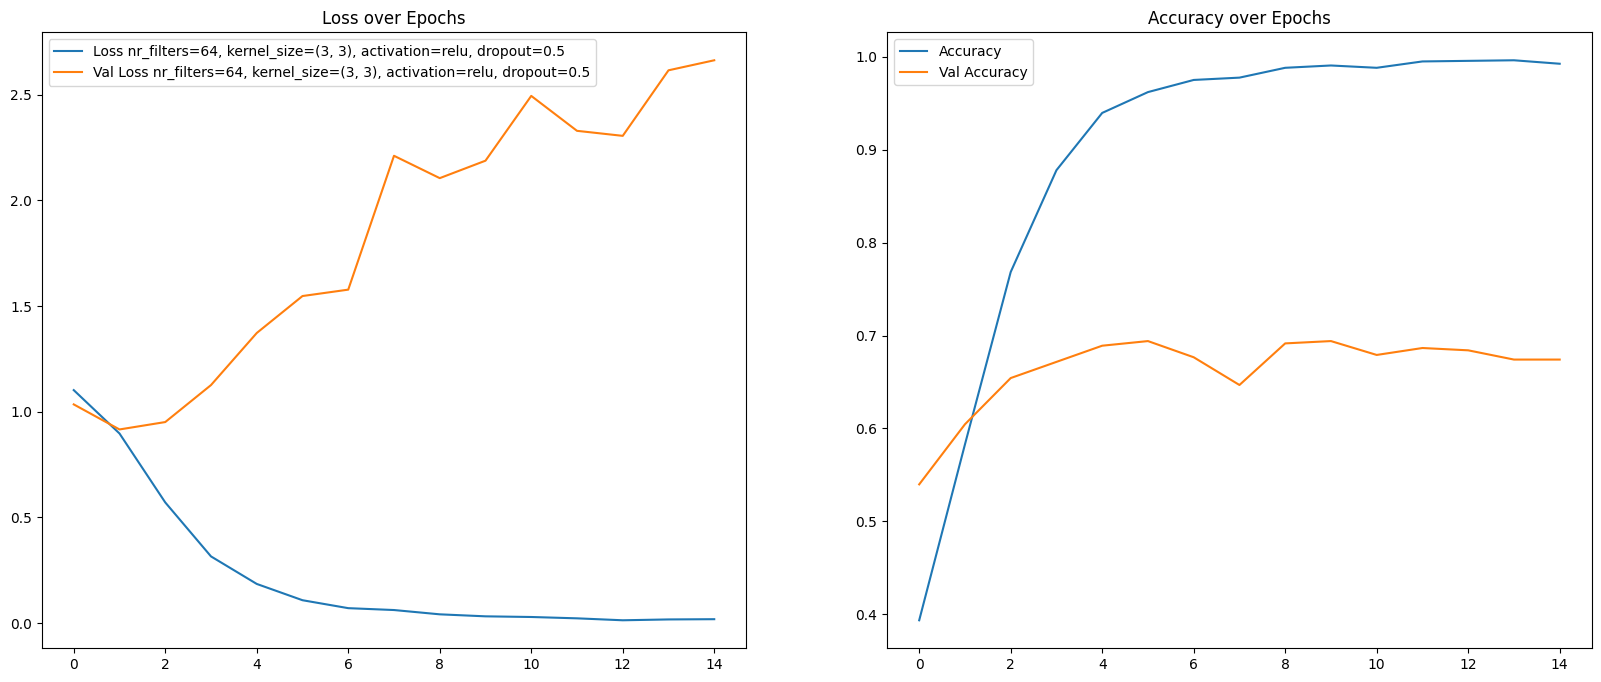

In [8]:
for label, history in histories:
    plt.figure(figsize=(20, 8))
    plt.subplot(1, 2, 1)
    plt.plot(history.history['loss'], label='Loss '+label)
    plt.plot(history.history['val_loss'], label='Val Loss '+label)
    plt.legend()
    plt.title("Loss over Epochs")
    
    plt.subplot(1, 2, 2)
    plt.plot(history.history['accuracy'], label='Accuracy')
    plt.plot(history.history['val_accuracy'], label='Val Accuracy')
    plt.legend()
    plt.title("Accuracy over Epochs")
    plt.show()

